In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load all centre raw data

import numpy as np
SMART_x = np.loadtxt('/content/drive/MyDrive/Thesis_code/SMARTData/Uncorrected_MedianFiltered_SizeMatched_SMART_x.csv', delimiter=',')
SMART_y = np.loadtxt('/content/drive/MyDrive/Thesis_code/SMARTData/Uncorrected_MedianFiltered_SizeMatched_SMART_y.csv', delimiter=',')
SMART_sample = np.loadtxt('/content/drive/MyDrive/Thesis_code/SMARTData/Uncorrected_MedianFiltered_SizeMatched_SMART_sampleID.csv', delimiter=',')
SMART_centre = np.loadtxt('/content/drive/MyDrive/Thesis_code/SMARTData/Uncorrected_MedianFiltered_SizeMatched_SMART_centre.csv', delimiter=',')
SMART_patient = np.loadtxt('/content/drive/MyDrive/Thesis_code/SMARTData/Uncorrected_MedianFiltered_SizeMatched_SMART_patientID.csv', delimiter=',')
SMART_wn = np.loadtxt('/content/drive/MyDrive/Thesis_code/SMARTData/Uncorrected_MedianFiltered_SizeMatched_SMART_wn.csv', delimiter=',')
SMART_uniquemapID = np.loadtxt('/content/drive/MyDrive/Thesis_code/SMARTData/Uncorrected_MedianFiltered_SizeMatched_SMART_mapID.csv', delimiter=',')

Raw_labels = {
  "NSQ": 0,
  "IM": 1,
  "LGD": 2,
  "HGD": 3,
  "AC": 4
}

Centre = {
  "GRH": 0,
  "UCL": 1,
  "UoE": 2
}

SMART_x = SMART_x.T

SMART_x.shape, SMART_y.shape, SMART_sample.shape, SMART_centre.shape, SMART_patient.shape, SMART_wn.shape, SMART_uniquemapID.shape


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((560819, 891), (560819,), (560819,), (560819,), (560819,), (891,), (560819,))

In [ ]:
def remove_saturations(spectra, labels, centre = None, patient = None, sample = None, sats = 400):
    """
    Takes in a dataset of Raman spectra and removes samples that have been saturated.

    sats defines the number of contiguous zeros to tolerate in any single spectra"""
    # Identify saturated spectra
    saturated_indices = []
    for i in range(spectra.shape[0]):
        if np.count_nonzero(spectra[i,:]==0) > sats:
            saturated_indices.append(i)

    # Remove saturated spectra
    non_none_vars = [] # Keeps track of variables to output
    unsaturated_spectra = np.delete(spectra, saturated_indices, axis=0)
    non_none_vars.append('spectra')
    unsaturated_labels = np.delete(labels, saturated_indices, axis=0)
    non_none_vars.append('labels')
    if centre is not None:
        unsaturated_centre = np.delete(centre, saturated_indices, axis=0)
        non_none_vars.append('centre')
    if patient is not None:
        unsaturated_patient = np.delete(patient, saturated_indices, axis=0)
        non_none_vars.append('patient')
    if sample is not None:
        unsaturated_sample = np.delete(sample, saturated_indices, axis=0)
        non_none_vars.append('sample')
    print('Active output variable names:', non_none_vars)
    # return spectra, labels, centre, patient, sample
    # Return non-None outputs
    return (x for x in (unsaturated_spectra, unsaturated_labels, unsaturated_centre, unsaturated_patient, unsaturated_sample) if x is not None)



In [ ]:
def MapandSpectraCount(raw_y, uniqueID, labels):
    """
    Function which counts the number of individual maps and spectra present in each label class

    Inputs:
        raw_y - a vector of integer labels
        uniqueID - a vector denoting unique ID
        labels - a dictionary of the labels to be used

    Outputs:
        MapCount - a vector giving the count maps per of labels
        SpectraCount - a vector giving the count spectra per of labels

    """

    number_of_labels = len(labels)

    MapCount = np.zeros(number_of_labels)
    SpectraCount = np.zeros(number_of_labels)

    for i in range(number_of_labels):
        MapCount[i] = len(np.unique(uniqueID[raw_y == i]))
        SpectraCount[i] = len(uniqueID[raw_y == i])



    return MapCount, SpectraCount

In [ ]:
MapandSpectraCount(SMART_y, SMART_patient, Raw_labels)

(array([16., 17.,  6.,  5.,  7.]),
 array([196505., 188088.,  51924.,  40429.,  83873.]))

In [ ]:
SMART_x, SMART_y, SMART_centre, SMART_patient, SMART_uniquemapID = remove_saturations(SMART_x, SMART_y, SMART_centre, SMART_patient, SMART_uniquemapID, sats = 400)
MapandSpectraCount(SMART_y, SMART_patient, Raw_labels)

Active output variable names: ['spectra', 'labels', 'centre', 'patient', 'sample']


(array([16., 17.,  6.,  5.,  7.]),
 array([196505., 188071.,  51924.,  40429.,  83873.]))

In [ ]:
sum(sum(np.isnan(SMART_x)))

0

In [ ]:
# SNV Normalise

import numpy as np

def norm_spectra(spec):
    """spec - a matrix of spectra of dimension: number of spectra x wavenumber"""
    """normed_spec = a matrix of 'individual' SNV normalised spectra"""

    normed_spec = np.zeros(spec.shape)

    for i in range(0, spec.shape[0]):
        normed_spec[i] = (spec[i] - np.mean(spec[i]))/np.std(spec[i])

    return normed_spec

In [ ]:
def truncate_spectra_to_region(wn, spectra, trunc_start = 400, trunc_end = 1800):
    """
    Function to truncate spectra within a specified region, default to the fingerprint region
    Inputs:
        wn - an array (vector) of the wavenumbers
        spectra - an array (matrix) of spectra (spectra in the rows)
        trunc_start - start of wavenumber region to be included
        trunc_end - end of wavenumber region to be included
    Outputs:

    """

    if trunc_start > trunc_end:
        print("ERROR: Start of region must be lower than end of region")
        pass

    closest_top_wn = min(wn, key=lambda x:abs(x-trunc_end))
    closest_bottom_wn = min(wn, key=lambda x:abs(x-trunc_start))

    max_wn = np.where(wn == closest_top_wn)
    min_wn = np.where(wn == closest_bottom_wn)

    trunc_spectra = spectra[:,np.squeeze(max_wn):np.squeeze(min_wn)]
    trunc_wn = wn[np.squeeze(max_wn):np.squeeze(min_wn)]

    return trunc_spectra, trunc_wn

In [ ]:
SMART_x, SMART_wn = truncate_spectra_to_region(SMART_wn, SMART_x, trunc_start = 450, trunc_end = 1800)
SMART_x = norm_spectra(SMART_x)
SMART_x.shape

(560802, 677)

In [ ]:
# Custom class for stratification by group.
# Taken from: https://www.kaggle.com/realsid/stratifiedgroupkfold-using-sklearn

from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits
from sklearn.utils.validation import check_random_state, column_or_1d
from sklearn.utils.multiclass import type_of_target
from collections import defaultdict

class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.
    This cross-validation object is a variation of StratifiedKFold attempts to
    return stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class as much as possible given the
    constraint of non-overlapping groups between splits.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.
        This implementation can only shuffle groups that have approximately the
        same y distribution, no global shuffle will be performed.
    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
           [0 0 1 1 1 0 0 0 0 0 0]
     TEST: [3 3 3 6 6 7]
           [1 1 1 0 0 0]
    TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
           [1 1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 2 2 8 8]
           [0 0 1 1 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]
    Notes
    -----
    The implementation is designed to:
    * Mimic the behavior of StratifiedKFold as much as possible for trivial
      groups (e.g. when each group contains only one sample).
    * Be invariant to class label: relabelling ``y = ["Happy", "Sad"]`` to
      ``y = [1, 0]`` should not change the indices generated.
    * Stratify based on samples as much as possible while keeping
      non-overlapping groups constraint. That means that in some cases when
      there is a small number of groups containing a large number of samples
      the stratification will not be possible and the behavior will be close
      to GroupKFold.
    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).
    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    def _iter_test_indices(self, X, y, groups):
        # Implementation is based on this kaggle kernel:
        # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
        # and is a subject to Apache 2.0 License. You may obtain a copy of the
        # License at http://www.apache.org/licenses/LICENSE-2.0
        # Changelist:
        # - Refactored function to a class following scikit-learn KFold
        #   interface.
        # - Added heuristic for assigning group to the least populated fold in
        #   cases when all other criteria are equal
        # - Swtch from using python ``Counter`` to ``np.unique`` to get class
        #   distribution
        # - Added scikit-learn checks for input: checking that target is binary
        #   or multiclass, checking passed random state, checking that number
        #   of splits is less than number of members in each class, checking
        #   that least populated class has more members than there are splits.
        rng = check_random_state(self.random_state)
        y = np.asarray(y)
        type_of_target_y = type_of_target(y)
        allowed_target_types = ('binary', 'multiclass')
        if type_of_target_y not in allowed_target_types:
            raise ValueError(
                'Supported target types are: {}. Got {!r} instead.'.format(
                    allowed_target_types, type_of_target_y))

        y = column_or_1d(y)
        _, y_inv, y_cnt = np.unique(y, return_inverse=True, return_counts=True)
        if np.all(self.n_splits > y_cnt):
            raise ValueError("n_splits=%d cannot be greater than the"
                             " number of members in each class."
                             % (self.n_splits))
        n_smallest_class = np.min(y_cnt)
        if self.n_splits > n_smallest_class:
            warnings.warn(("The least populated class in y has only %d"
                           " members, which is less than n_splits=%d."
                           % (n_smallest_class, self.n_splits)), UserWarning)
        n_classes = len(y_cnt)


        _, groups_inv, groups_cnt = np.unique(
            groups, return_inverse=True, return_counts=True)
        y_counts_per_group = np.zeros((len(groups_cnt), n_classes))
        for class_idx, group_idx in zip(y_inv, groups_inv):
            y_counts_per_group[group_idx, class_idx] += 1

        y_counts_per_fold = np.zeros((self.n_splits, n_classes))
        groups_per_fold = defaultdict(set)

        if self.shuffle:
            rng.shuffle(y_counts_per_group)

        # Stable sort to keep shuffled order for groups with the same
        # class distribution variance
        sorted_groups_idx = np.argsort(-np.std(y_counts_per_group, axis=1),
                                       kind='mergesort')

        for group_idx in sorted_groups_idx:
            group_y_counts = y_counts_per_group[group_idx]
            best_fold = self._find_best_fold(
                y_counts_per_fold=y_counts_per_fold, y_cnt=y_cnt,
                group_y_counts=group_y_counts)
            y_counts_per_fold[best_fold] += group_y_counts
            groups_per_fold[best_fold].add(group_idx)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group_idx in enumerate(groups_inv)
                            if group_idx in groups_per_fold[i]]
            yield test_indices

    def _find_best_fold(
            self, y_counts_per_fold, y_cnt, group_y_counts):
        best_fold = None
        min_eval = np.inf
        min_samples_in_fold = np.inf
        for i in range(self.n_splits):
            y_counts_per_fold[i] += group_y_counts
            # Summarise the distribution over classes in each proposed fold
            std_per_class = np.std(
                y_counts_per_fold / y_cnt.reshape(1, -1),
                axis=0)
            y_counts_per_fold[i] -= group_y_counts
            fold_eval = np.mean(std_per_class)
            samples_in_fold = np.sum(y_counts_per_fold[i])
            is_current_fold_better = (
                fold_eval < min_eval or
                np.isclose(fold_eval, min_eval)
                and samples_in_fold < min_samples_in_fold
            )
            if is_current_fold_better:
                min_eval = fold_eval
                min_samples_in_fold = samples_in_fold
                best_fold = i
        return best_fold

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np


class SpectralDataset(Dataset):
    """
    Builds a dataset of spectral data. Use idxs to specify which samples to use
    for dataset - this allows for random splitting into training, validation,
    and test sets. Instead of passing in filenames for X and y, we can also
    pass in numpy arrays directly.
    """
    def __init__(self, X_fn, y_fn, idxs=None, transform=None):
        if type(X_fn) == str:
            self.X = np.load(X_fn)
        else:
            self.X = X_fn
        if type(y_fn) == str:
            self.y = np.load(y_fn)
        else:
            self.y = y_fn
        if idxs is None: idxs = np.arange(len(self.y))
        self.idxs = idxs
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        i = self.idxs[idx]
        x, y = self.X[i], self.y[i]
        x = np.expand_dims(x, axis=0)
        if self.transform:
            x = self.transform(x)
        return (x, y)


### TRANSFORMS ###


class GetInterval(object):
    """
    Gets an interval of each spectrum.
    """
    def __init__(self, min_idx, max_idx):
        self.min_idx = min_idx
        self.max_idx = max_idx

    def __call__(self, x):
        x = x[:,self.min_idx:self.max_idx]
        return x


class ToFloatTensor(object):
    """
    Converts numpy arrays to float Variables in Pytorch.
    """
    def __call__(self, x):
        x = torch.from_numpy(x).float()
        return x


### TRANSFORMS ###


def spectral_dataloader(X_fn, y_fn, idxs=None, batch_size=10, shuffle=True,
    num_workers=4, min_idx=None, max_idx=None, sampler=None):
    """
    Returns a DataLoader with spectral data.
    """
    transform_list = []
    if min_idx is not None and max_idx is not None:
        transform_list.append(GetInterval(min_idx, max_idx))
    transform_list.append(ToFloatTensor())
    transform = transforms.Compose(transform_list)
    dataset = SpectralDataset(X_fn, y_fn, idxs=idxs, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, sampler=sampler)
    return dataloader


def spectral_dataloaders(X_fn, y_fn, n_train=None, p_train=0.8, p_val=0.1,
    n_test=None, batch_size=10, shuffle=True, num_workers=4, min_idx=None,
    max_idx=None):
    """
    Returns train, val, and test DataLoaders by splitting the dataset randomly.
    Can also take X_fn and y_fn as numpy arrays.
    """
    if type(y_fn) == str:
        idxs = np.arange(len(np.load(y_fn)))
    else:
        idxs = np.arange(len(y_fn))
    np.random.shuffle(idxs)
    if n_train is None: n_train = int(p_train * len(idxs))
    n_val = int(p_val * n_train)
    val_idxs, train_idxs = idxs[:n_val], idxs[n_val:n_train]
    if n_test is None: test_idxs = idxs[n_train:]
    else: test_idxs = idxs[n_train:n_train+n_test]
    trainloader = spectral_dataloader(X_fn, y_fn, train_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    valloader = spectral_dataloader(X_fn, y_fn, val_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    testloader = spectral_dataloader(X_fn, y_fn, test_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    return (trainloader, valloader, testloader)

In [ ]:
# 3 layer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 20, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv1d(20, 40, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm1d(40),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv1d(40, 40, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(40),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1))
        self.fc1 = nn.Linear(4120, 60)
        self.fc2 = nn.Linear(60, 5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.2)
        out = self.fc2(out)


        return out


In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
# Fixed hyperparameters

n_epochs = 60
num_classes = 5

# Hyperparameters
#by mode
#learning_rate = 0.001
#batch_size = 256
#bymean
learning_rate = 5e-5
batch_size = 184

# Loss and optimizer
convnet = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)
cuda = torch.cuda.is_available()

# See model architecture
count_parameters(convnet)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| layer1.0.weight |    140     |
|  layer1.0.bias  |     20     |
| layer1.1.weight |     20     |
|  layer1.1.bias  |     20     |
| layer2.0.weight |    4000    |
|  layer2.0.bias  |     40     |
| layer2.1.weight |     40     |
|  layer2.1.bias  |     40     |
| layer3.0.weight |    4800    |
|  layer3.0.bias  |     40     |
| layer3.1.weight |     40     |
|  layer3.1.bias  |     40     |
|    fc1.weight   |   247200   |
|     fc1.bias    |     60     |
|    fc2.weight   |    300     |
|     fc2.bias    |     5      |
+-----------------+------------+
Total Trainable Params: 256805


256805

In [ ]:
del convnet

In [ ]:
from collections import Counter

def get_data_weights(train_data):
    """
    Function to extract the class distribution of a dataset and
    return those as weights reasy for input into a pytorch optimiser
    Input:
        train_data - the labels of the data from which to extract class distribution
    Output:
        max_label / torch.tensor([all_values]) - the realtive weights based on class distribution.
        The largest class will have a weight of one. The smallest class will have the largest weight.
    """
    from collections import Counter

    train_count = Counter(train_data)

    key_max = max(train_count.keys(), key=(lambda k: train_count[k]))
    max_label = train_count[key_max]

    all_values = np.array([train_count[k] for k in sorted(train_count.keys())]).flatten()
    all_values

    return max_label / torch.tensor([all_values])

In [ ]:
def plot_learning_curve(train_list, test_list, epochs):

    """
    Function to plot train and test learning curves, where train score calculated per batch, test score per epoch
    Inputs:
        train_list - List of training scores per batch.
        test_list - List of test scores per epoch
        epochs - Integer number of epochs
    Outputs:
        plt.show() - learning curve
    """

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    x1 = np.linspace(0, len(train_list), len(train_list))
    x2 = np.linspace(0, len(train_list), len(test_list))

    ax1.plot(x1,train_list)
    ax1.plot(x2,test_list)
    ax1.set_xlabel("Batch")
    ax1.set_ylabel("Accuracy")

    batch_list = np.linspace(0, x1.shape[0], epochs)
    batch_labels = [0,1,2,3,4]

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(batch_list)
    ax2.set_xticklabels(batch_labels)
    ax2.set_xlabel("Epoch")

    plt.show()

In [ ]:
# Cuda enabled version.

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def train_cnn(model, X_train, y_train, X_test, y_test, learning_rate = 0.0001, beta1 = 0.9, beta2 = 0.999, num_epochs = 30, batch_size = 16, early_stop = 5,weightedLoss = False, learning_curves = True, cuda = False):

    train_loader = spectral_dataloader(X_train,y_train,batch_size = batch_size, shuffle=True) # requires dataloader functions
    test_loader = spectral_dataloader(X_test,y_test,batch_size = batch_size, shuffle=False)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    test_acc_list = []
    test_logloss = []
    test_accuracy = []

            # Loss and optimizer

  #torch.manual_seed(3407) # If we want to fix random seed
    model = model() #this should be called before running the function so is not needed here
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    if weightedLoss:
        weight = np.squeeze(get_data_weights(y_train)).to(device) # Need to send all variables used in optimisation to the GPU, including this weights
        criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))
    cuda = torch.cuda.is_available()

    if cuda:
      model.cuda()

    # early stopping set-up
    best_val = 0
    no_improvement = 0
    max_no_improvement = early_stop

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        test_outputs_list = []
        test_predicted_list = []
        test_labels_list = []
        for i, (spectra, labels) in enumerate(train_loader):
            spectra, labels = spectra.cuda(), labels.cuda()
            # Run the forward pass

            outputs = model(spectra)
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.3f}, Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

                # Test the model
        print('Testing epoch {}'.format(epoch + 1))
        model.eval()
        with torch.no_grad():
            test_correct = 0
            test_total = 0
            for test_spectra, test_labels in test_loader:
                test_spectra, test_labels = test_spectra.cuda(), test_labels.cuda()
                test_outputs = model(test_spectra)
                test_outputs_list.append(test_outputs)
                test_labels_list.append(test_labels)
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_predicted_list.append(test_predicted)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()
                acc_te = test_correct / test_total
            test_acc_list.append(acc_te)

            print('Epoch {}: Test Accuracy {} %'.format(epoch+1,(acc_te) * 100))


                # Check performance for early stopping
        if acc_te > best_val or epoch == 0:
            best_val = acc_te
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= max_no_improvement:
            print('Finished early after {} epochs!'.format(epoch+1))
            break

    # Final train score on a single batch
    train_log_loss, train_accuracy, _ = test_a_batch(model ,X_train, y_train, batch_size )

    # Final test score on a single batch
    test_log_loss, test_accuracy, con_mat = test_a_batch(model ,X_test, y_test, batch_size )

    print('Final Training Accuracy {} %'.format((train_accuracy) * 100))
    print('Final Test Accuracy {} %'.format((test_accuracy) * 100))

    if learning_curves:
        plot_learning_curve(acc_list, test_acc_list, epoch)

    return model, con_mat, test_log_loss, test_accuracy, train_log_loss, train_accuracy, test_outputs_list, test_predicted_list


In [ ]:
def plot_learning_curve(train_list, test_list, epochs):

    """
    Function to plot train and test learning curves, where train score calculated per batch, test score per epoch
    Inputs:
        train_list - List of training scores per batch.
        test_list - List of test scores per epoch
        epochs - Integer number of epochs
    Outputs:
        plt.show() - learning curve
    """

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    x1 = np.linspace(0, len(train_list), len(train_list))
    x2 = np.linspace(0, len(train_list), len(test_list))

    ax1.plot(x1,train_list)
    ax1.plot(x2,test_list)
    ax1.set_xlabel("Batch")
    ax1.set_ylabel("Accuracy")

    batch_list = np.linspace(0, x1.shape[0], epochs)
    batch_labels = [0,1,2,3,4]

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(batch_list)
    ax2.set_xticklabels(batch_labels)
    ax2.set_xlabel("Epoch")

    plt.show()

In [ ]:
import numpy as np

def test_a_batch(model, X, y, cuda = True, batch_size = 16):

    """
    Function to take in a Pytorch neural network and some data and output the accuracy,
    confusion matrix and log loss

    Inputs:
        model - pytorch model
        X - data inputs compatible with the above model
        y - data labels
        batch_size - set low to ensure compatability even with poor memory CPUs

    Outputs:
        test_log_loss - log loss
        test_accuracy - accuracy
        con_mat - confusion matrix

    """

    test_loader = spectral_dataloader(X, y, batch_size = batch_size, shuffle=False)

    y_test_clas = get_predictions(model, test_loader, cuda, get_probs=False)
    y_test_pred = get_predictions(model, test_loader, cuda, get_probs=True)


    test_log_loss = metrics.log_loss(y, y_test_pred, labels = np.unique(y_train))
    test_accuracy = metrics.accuracy_score(y, y_test_clas)
    con_mat = confusion_matrix(y, y_test_clas)

    return test_log_loss, test_accuracy, con_mat


In [ ]:
def get_predictions(model, dataloader, cuda, get_probs=False):
    preds = []
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if cuda: inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs), Variable(targets.long())
        outputs = model(inputs)
        if get_probs:
            probs = torch.nn.functional.softmax(outputs, dim=1)
            if cuda: probs = probs.data.cpu().numpy()
            else: probs = probs.data.numpy()
            preds.append(probs)
        else:
            _, predicted = torch.max(outputs.data, 1)
            if cuda: predicted = predicted.cpu()
            preds += list(predicted.numpy().ravel())
    if get_probs:
        return np.vstack(preds)
    else:
        return np.array(preds)

In [ ]:
from collections import Counter

def get_normalised_sample_score(counter_object, y_train):
    """
    Takes a collections count of a single sample and an array of labels and return a numerically oredered np.array of the values of the object
    Input:
    collections object
    y_train
    Outouts: np.array of values
    """

    # First, create an empty dictionary with keys equal to the possible values

    counter_dict = {}
    for d_class in np.unique(y_train):
        counter_dict[d_class] = 0

    # Then, iterate through the counter_object and map the values to the keys in the dictionary
    for key, value in counter_object.items():
        counter_dict[key] = value

    norm_values = []
    for key, value in counter_dict.items():
        norm_values.append(value)
    norm_values = np.array(norm_values)
    norm_values = norm_values / np.sum(norm_values)

    return norm_values

def simple_consensus_sample_CNN(model, sample_spectra, sample_labels, y_train, batch_size = 64):
    """
    Function to classify a single sample with multiple spectra based on consensus. Simple majority wins.
    Inputs:
        svm_model - trained svm model
        sample_spectra - spectra to be classified belonging to a single sample
        sample_labels - label of the sample being classified. Should only be one label.
        y_train - All possible labels.
    Outputs:
        true_sample_label - the true sample label
        predicted_sample_label - the samples predicted label
        predictions - returns proportion for each class
    """

    true_sample_label = np.unique(sample_labels)
    if len(true_sample_label) > 1:
        print("More than one label was present in the sample.")
        return


    test_data = spectral_dataloader(sample_spectra,sample_labels,batch_size = batch_size, shuffle=False)
    test_pred = get_predictions(model, test_data, cuda)
    c = Counter(test_pred)
    predictions = get_normalised_sample_score(c, y_train)
    predicted_sample_label = max(c, key=c.get)

    return true_sample_label, predicted_sample_label, predictions


def sample_accuracy_batch(model, centre, uniquemapID, centre_train, batch_spectra, batch_labels, proportioned = False ):
    """
        Function to classify an entire batch of samples which have multiple spectra based on consensus. Simple majority wins.
    Inputs:
        pca_model - trained pca model
        lda_model - trained lda model
        uniquemapID - a list of every single unique sample in the data
        centre_train - the centre (or other indices) from which to extract a batch
        batch_spectra - ALL spectra in the dataset
        batch_labels -  ALL labels in the dataset
        proportioned - If TRUE classifies using proportional consensus, otherwise by simple consensus
    Outputs:
        y_sample_label - the true sample labels
        y_sample_clas - the samples predicted labels
        y_sample_predictions - gives proportions of pixel votes per sample as a list
    """

    y_sample_label = []
    y_sample_clas = []
    y_sample_predictions = []

    training_samples = uniquemapID[centre == centre_train]


    for sample in np.unique(training_samples):
        if proportioned == True:
            sam_lab, sam_clas = proportional_consensus_sample_CNN(model, batch_spectra[uniquemapID == sample], batch_labels[uniquemapID == sample])
            y_sample_label.append(sam_lab), y_sample_clas.append(sam_clas)

        if proportioned == False:
            sam_lab, sam_clas, predictions = simple_consensus_sample_CNN(model, batch_spectra[uniquemapID == sample], batch_labels[uniquemapID == sample], y_train)
            y_sample_label.append(sam_lab), y_sample_clas.append(sam_clas), y_sample_predictions.append(predictions)

    y_sample_label = np.array(y_sample_label)
    y_sample_clas = np.array(y_sample_clas)

    return y_sample_label, y_sample_clas, y_sample_predictions


def sample_accuracy_whole(model, uniquemapID, batch_spectra, batch_labels, y_train, proportioned = False ):
    """
        Function to classify an entire batch of samples which have multiple spectra based on consensus.
    Inputs:
        svm_model - trained svm model
        uniquemapID - a list of every single unique sample in the data
        batch_spectra - ALL spectra in the dataset
        batch_labels -  ALL labels in the dataset
        y_train - array of all possible classes. Can be any size but must contain all possible class labels
        proportioned - If TRUE classifies using proportional consensus, otherwise by simple consensus
    Outputs:
        y_sample_label - the true sample labels
        y_sample_clas - the samples predicted labels
        prediction - gives proportions of pixel votes per sample as a list
    """

    y_sample_label = []
    y_sample_clas = []
    y_sample_predictions = []


    for sample in np.unique(uniquemapID):
        if proportioned == True:
            sam_lab, sam_clas = proportional_consensus_sample_CNN(model, batch_spectra[uniquemapID == sample], batch_labels[uniquemapID == sample])
            y_sample_label.append(sam_lab), y_sample_clas.append(sam_clas)

        if proportioned == False:
            sam_lab, sam_clas, predictions = simple_consensus_sample_CNN(model, batch_spectra[uniquemapID == sample], batch_labels[uniquemapID == sample], y_train)
            y_sample_label.append(sam_lab), y_sample_clas.append(sam_clas), y_sample_predictions.append(predictions)

    y_sample_label = np.array(y_sample_label)
    y_sample_clas = np.array(y_sample_clas)

    return y_sample_label, y_sample_clas, y_sample_predictions



In [ ]:
# Train on one centre, test on two

from sklearn import metrics
from sklearn.model_selection import LeaveOneGroupOut

n_epochs = 60

gkf = LeaveOneGroupOut()

for test_index, train_index in gkf.split(SMART_x, SMART_y, groups=SMART_centre): #(note switching of test/train indices here as we are leaving out 2 centres)

    X_train, X_test = SMART_x[train_index], SMART_x[test_index]
    y_train, y_test = SMART_y[train_index], SMART_y[test_index]
    centre_train = np.unique(SMART_centre[train_index])
    centre_test = np.unique(SMART_centre[test_index])
    group_train = SMART_centre[train_index]
    group_test = SMART_centre[test_index]
    centre_test_1 = np.unique(SMART_centre[test_index])[0]
    centre_test_2 = np.unique(SMART_centre[test_index])[1]

    print("Training Centre: {}".format(list(Centre.keys())[list(Centre.values()).index(centre_train)]))


    # Train CNN on the training and test data
    convnet, con_mat, test_ll, test_acc, train_ll, train_acc, test_outputs, test_predicted  = train_cnn(ConvNet, X_train, y_train, X_test, y_test, learning_rate = learning_rate, num_epochs = n_epochs, batch_size = batch_size, early_stop = 5, weightedLoss = True, learning_curves = False, , cuda = True)
    print("train accuracy: {}, train logloss: {}".format(train_acc,train_ll))
    print()

    y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_batch(convnet, SMART_centre, SMART_uniquemapID, centre_train, SMART_x, SMART_y, proportioned = False )
    acc = metrics.accuracy_score(y_sample_label, y_sample_clas )
    ll = metrics.log_loss(y_sample_label, y_sample_preds, labels = np.unique(SMART_y)  )
    print("By sample accuracy: {}, log loss {}".format(acc, ll))



    # Test individual centres

    print("Test Centre: {}".format(list(Centre.keys())[list(Centre.values()).index(centre_test_1)]))
    ll, acc, _  = test_a_batch(convnet, SMART_x[SMART_centre == centre_test_1], SMART_y[SMART_centre == centre_test_1], batch_size = batch_size)

    print("By spectra accuracy: {}, logloss: {}".format(acc,ll))
    print()

    y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_batch(convnet, SMART_centre, SMART_uniquemapID, centre_test_1, SMART_x, SMART_y, proportioned = False )
    acc = metrics.accuracy_score(y_sample_label, y_sample_clas )
    ll = metrics.log_loss(y_sample_label, y_sample_preds, labels = np.unique(SMART_y) )
    print("By SAMPLE SIMPLE CONSENSUS test accuracy: {} logloss {}".format(acc, ll))
    print()

    print("Test Centre: {}".format(list(Centre.keys())[list(Centre.values()).index(centre_test_2)]))

    ll, acc, _  = test_a_batch(convnet, SMART_x[SMART_centre == centre_test_2], SMART_y[SMART_centre == centre_test_2], batch_size = batch_size)

    print("By spectra accuracy: {}, logloss: {}".format(acc,ll))
    print()


    y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_batch(convnet, SMART_centre, SMART_uniquemapID, centre_test_2, SMART_x, SMART_y, proportioned = False )
    acc = metrics.accuracy_score(y_sample_label, y_sample_clas )
    ll = metrics.log_loss(y_sample_label, y_sample_preds, labels = np.unique(SMART_y) )
    print("By SAMPLE SIMPLE CONSENSUS test accuracy: {} logloss {}".format(acc, ll))
    print()

    print()

Training Centre: GRH


<ipython-input-16-6ad01c70a6be>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return max_label / torch.tensor([all_values])


Epoch [1/60], Step [100/1048], Loss: 1.224, Training Accuracy: 58.15%
Epoch [1/60], Step [200/1048], Loss: 0.971, Training Accuracy: 70.65%
Epoch [1/60], Step [300/1048], Loss: 0.852, Training Accuracy: 74.46%
Epoch [1/60], Step [400/1048], Loss: 0.907, Training Accuracy: 71.74%
Epoch [1/60], Step [500/1048], Loss: 1.091, Training Accuracy: 68.48%
Epoch [1/60], Step [600/1048], Loss: 0.911, Training Accuracy: 64.67%
Epoch [1/60], Step [700/1048], Loss: 0.809, Training Accuracy: 74.46%
Epoch [1/60], Step [800/1048], Loss: 0.759, Training Accuracy: 73.91%
Epoch [1/60], Step [900/1048], Loss: 0.753, Training Accuracy: 78.26%
Epoch [1/60], Step [1000/1048], Loss: 0.692, Training Accuracy: 77.72%
Testing epoch 1
Epoch 1: Test Accuracy 64.73721957500909 %
Epoch [2/60], Step [100/1048], Loss: 0.843, Training Accuracy: 70.11%
Epoch [2/60], Step [200/1048], Loss: 0.794, Training Accuracy: 77.17%
Epoch [2/60], Step [300/1048], Loss: 0.795, Training Accuracy: 71.74%
Epoch [2/60], Step [400/1048],

In [ ]:
# 5x3 CV, All data together, one centre at a time centre

from sklearn import metrics
from sklearn.model_selection import LeaveOneGroupOut

n_repeats = 5
folds = 3

outer_accuracy = []
outer_log_loss = []
simple_sample_accuracy = []
simple_sample_logloss = []


for cen in np.unique(SMART_centre):
    centre_x = SMART_x[SMART_centre == cen]
    centre_y = SMART_y[SMART_centre == cen]
    centre_patient = SMART_patient[SMART_centre == cen]
    centre_sample = SMART_uniquemapID[SMART_centre == cen]
    print("Centre: {}".format(list(Centre.keys())[list(Centre.values()).index(cen)]))
    #MapandSpectraCount(centre_y, centre_patient, Raw_labels)
    counter = 0
    while counter < n_repeats*folds:
        sgkf = StratifiedGroupKFold(folds, shuffle = True)
        for train_index, test_index in sgkf.split(centre_x, centre_y, groups=centre_patient): #(note switching of test/train indices here as we are leaving out 2 centres)

            X_train, X_test = centre_x[train_index], centre_x[test_index]
            y_train, y_test = centre_y[train_index], centre_y[test_index]
            group_train, group_test = centre_sample[train_index], centre_sample[test_index]

            convnet, con_mat, test_ll, test_acc, train_ll, train_acc, test_outputs, test_predicted  = train_cnn(ConvNet, X_train, y_train, X_test, y_test, learning_rate = learning_rate, num_epochs = n_epochs, batch_size = batch_size, early_stop = 5, weightedLoss = True, learning_curves = False)

            outer_accuracy.append(test_acc)
            outer_log_loss.append(test_ll)

            y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_whole(convnet, group_test, X_test, y_test, SMART_y, proportioned = False )

            acc = metrics.accuracy_score(y_sample_label, y_sample_clas )
            ll = metrics.log_loss(y_sample_label, y_sample_preds, labels = np.unique(SMART_y) )
            simple_sample_accuracy.append(acc)
            simple_sample_logloss.append(ll)


            counter = counter+1
    print("By Spectra accuracy: {} +/- {}".format(np.mean(outer_accuracy),np.std(outer_accuracy)))
    print("By Sample simple accuracy: {} +/- {}".format(np.mean(simple_sample_accuracy),np.std(simple_sample_accuracy)))
    print("By Sample simple log loss: {} +/- {}".format(np.mean(simple_sample_logloss),np.std(simple_sample_logloss)))


Streaming output truncated to the last 5000 lines.
Epoch [6/60], Step [100/735], Loss: 0.413, Training Accuracy: 89.13%
Epoch [6/60], Step [200/735], Loss: 0.563, Training Accuracy: 84.24%
Epoch [6/60], Step [300/735], Loss: 0.438, Training Accuracy: 86.41%
Epoch [6/60], Step [400/735], Loss: 0.347, Training Accuracy: 89.67%
Epoch [6/60], Step [500/735], Loss: 0.390, Training Accuracy: 85.33%
Epoch [6/60], Step [600/735], Loss: 0.317, Training Accuracy: 89.67%
Epoch [6/60], Step [700/735], Loss: 0.339, Training Accuracy: 87.50%
Testing epoch 6
Epoch 6: Test Accuracy 56.03466240622396 %
Epoch [7/60], Step [100/735], Loss: 0.287, Training Accuracy: 90.22%
Epoch [7/60], Step [200/735], Loss: 0.352, Training Accuracy: 86.96%
Epoch [7/60], Step [300/735], Loss: 0.366, Training Accuracy: 88.04%
Epoch [7/60], Step [400/735], Loss: 0.405, Training Accuracy: 87.50%
Epoch [7/60], Step [500/735], Loss: 0.289, Training Accuracy: 89.67%
Epoch [7/60], Step [600/735], Loss: 0.413, Training Accuracy: 

In [ ]:
# No hyperparameter search

from sklearn import metrics
from sklearn.model_selection import LeaveOneGroupOut


n_repeats = 5
folds = 3


outer_accuracy = []
outer_log_loss = []
simple_sample_accuracy = []
simple_sample_logloss = []


counter = 0
while counter < n_repeats*folds:
    sgkf = StratifiedGroupKFold(folds, shuffle = True)
    for train_index, test_index in sgkf.split(SMART_x, SMART_y, groups=SMART_patient): #(note switching of test/train indices here as we are leaving out 2 centres)

        X_train, X_test = SMART_x[train_index], SMART_x[test_index]
        y_train, y_test = SMART_y[train_index], SMART_y[test_index]
        group_train, group_test = SMART_uniquemapID[train_index], SMART_uniquemapID[test_index]

        convnet, con_mat, test_ll, test_acc, train_ll, train_acc, test_outputs, test_predicted  = train_cnn(ConvNet, X_train, y_train, X_test, y_test, learning_rate = learning_rate, num_epochs = n_epochs, batch_size = batch_size, early_stop = 5, learning_curves = False)

        outer_accuracy.append(test_acc)
        outer_log_loss.append(test_ll)

        # By simple sample accuracy
        y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_whole(convnet, group_test, X_test, y_test, SMART_y, proportioned = False )
        acc = metrics.accuracy_score(y_sample_label, y_sample_clas )
        ll = metrics.log_loss(y_sample_label, y_sample_preds, labels = np.unique(SMART_y) )
        simple_sample_accuracy.append(acc)
        simple_sample_logloss.append(ll)

        counter = counter+1
print("By spectra accuracy: {} +/- {}".format(np.mean(outer_accuracy),np.std(outer_accuracy)))
print("By spectra log loss: {} +/- {}".format(np.mean(outer_log_loss),np.std(outer_log_loss)))
print("By simple sample log loss: {} +/- {}".format(np.mean(simple_sample_logloss),np.std(simple_sample_logloss)))
print("By simple sample accuracy: {} +/- {}".format(np.mean(simple_sample_accuracy),np.std(simple_sample_accuracy)))


Epoch [1/60], Step [100/2007], Loss: 0.954, Training Accuracy: 66.85%
Epoch [1/60], Step [200/2007], Loss: 0.837, Training Accuracy: 73.91%
Epoch [1/60], Step [300/2007], Loss: 0.844, Training Accuracy: 69.02%
Epoch [1/60], Step [400/2007], Loss: 0.815, Training Accuracy: 69.02%
Epoch [1/60], Step [500/2007], Loss: 0.716, Training Accuracy: 75.54%
Epoch [1/60], Step [600/2007], Loss: 0.647, Training Accuracy: 76.09%
Epoch [1/60], Step [700/2007], Loss: 0.719, Training Accuracy: 73.91%
Epoch [1/60], Step [800/2007], Loss: 0.737, Training Accuracy: 72.28%
Epoch [1/60], Step [900/2007], Loss: 0.708, Training Accuracy: 72.28%
Epoch [1/60], Step [1000/2007], Loss: 0.639, Training Accuracy: 73.91%
Epoch [1/60], Step [1100/2007], Loss: 0.550, Training Accuracy: 82.61%
Epoch [1/60], Step [1200/2007], Loss: 0.626, Training Accuracy: 76.63%
Epoch [1/60], Step [1300/2007], Loss: 0.583, Training Accuracy: 77.72%
Epoch [1/60], Step [1400/2007], Loss: 0.586, Training Accuracy: 78.26%
Epoch [1/60], S

In [ ]:
# Train model on entire data

In [ ]:
early_epochs = [7,18,6,15,9,17,22,12,24,6,17,14,12]
np.mean(early_epochs)

13.76923076923077

In [ ]:
# Train CNN with no CV

# by geometric mean
learning_rate = 0.0002
batch_size = 98
num_epochs = 13

    # perform CNN

train_loader = spectral_dataloader(SMART_x,SMART_y,batch_size = batch_size, shuffle=True) # requires dataloader functions

total_step = len(train_loader)


            # Loss and optimizer

model = ConvNet() #this should be called before running the function so is not needed here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = np.squeeze(get_data_weights(y_train)).to(device) # Need to send all variables used in optimisation to the GPU, including this weights
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
cuda = torch.cuda.is_available()
model.cuda()

loss_list = []
acc_list = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    for i, (spectra, labels) in enumerate(train_loader):
        spectra, labels = spectra.cuda(), labels.cuda()

            # Run the forward pass
        outputs = model(spectra)
        loss = criterion(outputs, labels.long())
        loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

            # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.3f}, Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))


y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_whole(model, SMART_uniquemapID, SMART_x, SMART_y, SMART_y, proportioned = False )
con_mat = confusion_matrix(y_sample_label, y_sample_clas)
ll = metrics.log_loss(y_sample_label, y_sample_preds,  labels = np.unique(SMART_y))
acc = metrics.accuracy_score(y_sample_label, y_sample_clas)

print(" Accuracy: {}".format(acc))
print(" Log Loss{}".format(ll))



Epoch [1/13], Step [100/5723], Loss: 1.369, Training Accuracy: 34.69%
Epoch [1/13], Step [200/5723], Loss: 1.115, Training Accuracy: 56.12%
Epoch [1/13], Step [300/5723], Loss: 1.154, Training Accuracy: 51.02%
Epoch [1/13], Step [400/5723], Loss: 1.209, Training Accuracy: 58.16%
Epoch [1/13], Step [500/5723], Loss: 1.146, Training Accuracy: 55.10%
Epoch [1/13], Step [600/5723], Loss: 1.015, Training Accuracy: 53.06%
Epoch [1/13], Step [700/5723], Loss: 0.852, Training Accuracy: 69.39%
Epoch [1/13], Step [800/5723], Loss: 1.066, Training Accuracy: 59.18%
Epoch [1/13], Step [900/5723], Loss: 1.071, Training Accuracy: 47.96%
Epoch [1/13], Step [1000/5723], Loss: 0.939, Training Accuracy: 67.35%
Epoch [1/13], Step [1100/5723], Loss: 0.951, Training Accuracy: 64.29%
Epoch [1/13], Step [1200/5723], Loss: 1.063, Training Accuracy: 63.27%
Epoch [1/13], Step [1300/5723], Loss: 1.296, Training Accuracy: 58.16%
Epoch [1/13], Step [1400/5723], Loss: 0.996, Training Accuracy: 58.16%
Epoch [1/13], S

In [ ]:
# Save the model

torch.save(model.state_dict(), '/content/drive/MyDrive/ML/ALLSMART_FINAL_CNN')

In [ ]:
# Create ROC curves for leave two out CV

In [ ]:
# Train on one centre, test on two
# No hyperparameter search

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut


cnn_test_logloss = []
cnn_test_accuracy = []
cnn_test_logloss = []
cnn_test_confusion_matrix = []
labels = []
predictions = []


learning_rate = 0.0002
batch_size = 98
n_epochs = 60

gkf = LeaveOneGroupOut()

for test_index, train_index in gkf.split(SMART_x, SMART_y, groups=SMART_centre): #(note switching of test/train indices here as we are leaving out 2 centres)

    X_train, X_test = SMART_x[train_index], SMART_x[test_index]
    y_train, y_test = SMART_y[train_index], SMART_y[test_index]
    centre_train = np.unique(SMART_centre[train_index])
    centre_test = np.unique(SMART_centre[test_index])
    group_train = SMART_centre[train_index]
    group_test = SMART_centre[test_index]
    centre_test_1 = np.unique(SMART_centre[test_index])[0]
    centre_test_2 = np.unique(SMART_centre[test_index])[1]

    print("Training Centre: {}".format(list(Centre.keys())[list(Centre.values()).index(centre_train)]))


    # Train CNN on the training and test data
    convnet, con_mat, test_ll, test_acc, train_ll, train_acc, test_outputs, test_predicted  = train_cnn(ConvNet, X_train, y_train, X_test, y_test, learning_rate = learning_rate, num_epochs = n_epochs, batch_size = batch_size, early_stop = 5, weightedLoss = True, learning_curves = False)
    print("train accuracy: {}, train logloss: {}".format(train_acc,train_ll))
    print()

    y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_batch(convnet, SMART_centre, SMART_uniquemapID, centre_train, SMART_x, SMART_y, proportioned = False )
    acc = metrics.accuracy_score(y_sample_label, y_sample_clas )
    ll = metrics.log_loss(y_sample_label, y_sample_preds, labels = np.unique(SMART_y)  )
    print("By sample accuracy: {}, log loss {}".format(acc, ll))



    # Test individual centres

    print("Test Centre: {}".format(list(Centre.keys())[list(Centre.values()).index(centre_test_1)]))
    ll, acc, _  = test_a_batch(convnet, SMART_x[SMART_centre == centre_test_1], SMART_y[SMART_centre == centre_test_1], batch_size = batch_size)

    print("By spectra accuracy: {}, logloss: {}".format(acc,ll))
    print()

    y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_batch(convnet, SMART_centre, SMART_uniquemapID, centre_test_1, SMART_x, SMART_y, proportioned = False )
    acc = metrics.accuracy_score(y_sample_label, y_sample_clas )
    ll = metrics.log_loss(y_sample_label, y_sample_preds, labels = np.unique(SMART_y) )
    con_mat = confusion_matrix(y_sample_label, y_sample_clas)
    print("By SAMPLE SIMPLE CONSENSUS test accuracy: {} logloss {}".format(acc, ll))
    print()

    cnn_test_confusion_matrix.append(con_mat)
    cnn_test_accuracy.append(acc)
    cnn_test_logloss.append(ll)

    # These are for the ROC curves
    labels.append(y_sample_label)
    predictions.append(y_sample_preds)

    print("Test Centre: {}".format(list(Centre.keys())[list(Centre.values()).index(centre_test_2)]))

    ll, acc, _  = test_a_batch(convnet, SMART_x[SMART_centre == centre_test_2], SMART_y[SMART_centre == centre_test_2], batch_size = batch_size)

    print("By spectra accuracy: {}, logloss: {}".format(acc,ll))
    print()


    y_sample_label, y_sample_clas, y_sample_preds = sample_accuracy_batch(convnet, SMART_centre, SMART_uniquemapID, centre_test_2, SMART_x, SMART_y, proportioned = False )
    acc = metrics.accuracy_score(y_sample_label, y_sample_clas )
    ll = metrics.log_loss(y_sample_label, y_sample_preds, labels = np.unique(SMART_y) )
    con_mat = confusion_matrix(y_sample_label, y_sample_clas)
    print("By SAMPLE SIMPLE CONSENSUS test accuracy: {} logloss {}".format(acc, ll))
    print()

    cnn_test_confusion_matrix.append(con_mat)
    cnn_test_accuracy.append(acc)
    cnn_test_logloss.append(ll)

    # These are for the ROC curves
    labels.append(y_sample_label)
    predictions.append(y_sample_preds)



    print()

Training Centre: GRH


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epoch [1/60], Step [100/1967], Loss: 1.346, Training Accuracy: 62.24%
Epoch [1/60], Step [200/1967], Loss: 1.081, Training Accuracy: 58.16%
Epoch [1/60], Step [300/1967], Loss: 0.988, Training Accuracy: 65.31%
Epoch [1/60], Step [400/1967], Loss: 0.859, Training Accuracy: 69.39%
Epoch [1/60], Step [500/1967], Loss: 0.982, Training Accuracy: 69.39%
Epoch [1/60], Step [600/1967], Loss: 0.764, Training Accuracy: 75.51%
Epoch [1/60], Step [700/1967], Loss: 0.721, Training Accuracy: 77.55%
Epoch [1/60], Step [800/1967], Loss: 0.837, Training Accuracy: 76.53%
Epoch [1/60], Step [900/1967], Loss: 0.984, Training Accuracy: 67.35%
Epoch [1/60], Step [1000/1967], Loss: 0.710, Training Accuracy: 75.51%
Epoch [1/60], Step [1100/1967], Loss: 0.849, Training Accuracy: 73.47%
Epoch [1/60], Step [1200/1967], Loss: 0.673, Training Accuracy: 75.51%
Epoch [1/60], Step [1300/1967], Loss: 0.998, Training Accuracy: 63.27%
Epoch [1/60], Step [1400/1967], Loss: 0.695, Training Accuracy: 78.57%
Epoch [1/60], S

In [ ]:
def one_hot_vector(test_y):
    """Function to turn a vector of five labels into one hot vector form
    Input:
        An nx1 vector of labels

    Output:
        An nx5 vector of labels

    """

    raw_y_one_hot_clas = np.zeros([test_y.shape[0], 5])

    for i in range(0, len(test_y)):
        if test_y[i] == 0:
            raw_y_one_hot_clas[i,0] = 1
        elif test_y[i] == 1:
            raw_y_one_hot_clas[i,1] = 1
        elif test_y[i] == 2:
            raw_y_one_hot_clas[i,2] = 1
        elif test_y[i] == 3:
            raw_y_one_hot_clas[i,3] = 1
        elif test_y[i] == 4:
            raw_y_one_hot_clas[i,4] = 1

    return raw_y_one_hot_clas

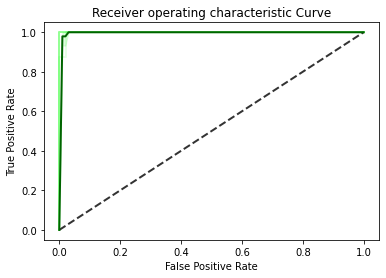

In [ ]:
from sklearn.metrics import roc_curve, auc

which_class = 0
n_classes = 5
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#plt.figure()
fig, ax = plt.subplots()
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[which_class], tpr[which_class], color='lime',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2],alpha=.1)

    interp_tpr = np.interp(mean_fpr, fpr[which_class], tpr[which_class])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[which_class])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkgreen',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=1)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='palegreen', alpha=.3,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic Curve")
#ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

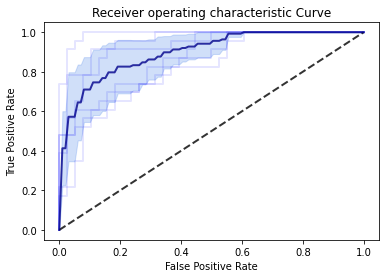

In [ ]:
from sklearn.metrics import roc_curve, auc

which_class = 1
n_classes = 5
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#plt.figure()
fig, ax = plt.subplots()
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[which_class], tpr[which_class], color='blue',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1],alpha=.1)

    interp_tpr = np.interp(mean_fpr, fpr[which_class], tpr[which_class])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[which_class])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkblue',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='cornflowerblue', alpha=.3,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic Curve")
#ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

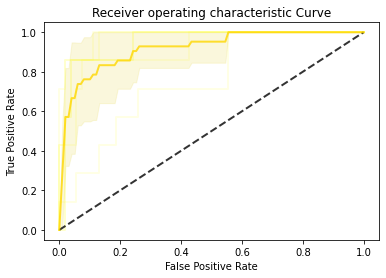

In [ ]:
from sklearn.metrics import roc_curve, auc

which_class = 2
n_classes = 5
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#plt.figure()
fig, ax = plt.subplots()
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[which_class], tpr[which_class], color='yellow',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2],alpha=.1)

    interp_tpr = np.interp(mean_fpr, fpr[which_class], tpr[which_class])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[which_class])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='gold',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='khaki', alpha=.3,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic Curve")
#ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

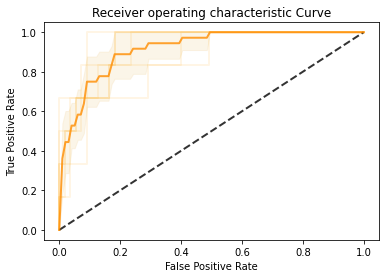

In [ ]:
from sklearn.metrics import roc_curve, auc

which_class = 3
n_classes = 5
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#plt.figure()
fig, ax = plt.subplots()
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[which_class], tpr[which_class], color='orange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2],alpha=.1)

    interp_tpr = np.interp(mean_fpr, fpr[which_class], tpr[which_class])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[which_class])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkorange',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='wheat', alpha=.3,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic Curve")
#ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

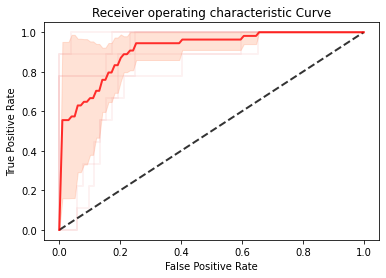

In [ ]:
from sklearn.metrics import roc_curve, auc

which_class = 4
n_classes = 5
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#plt.figure()
fig, ax = plt.subplots()
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[which_class], tpr[which_class], color='lightcoral',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2],alpha=.1)

    interp_tpr = np.interp(mean_fpr, fpr[which_class], tpr[which_class])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[which_class])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='red',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightsalmon', alpha=.3,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic Curve")
#ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

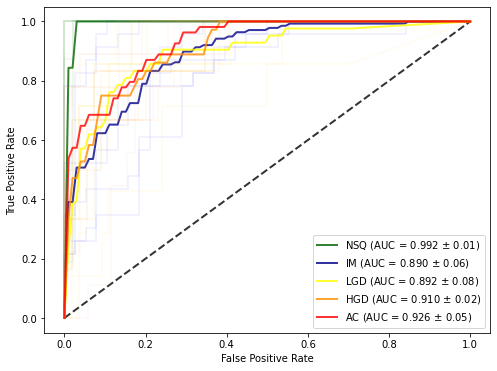

In [ ]:
from sklearn.metrics import roc_curve, auc

n_classes = 5
lw = 2
tprs = []
aucs = []
cls = 0
mean_fpr = np.linspace(0, 1, 100)

#plt.figure()
#figsize=(10,5)
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[cls], tpr[cls], color='green',lw=lw,alpha=.05)

    interp_tpr = np.interp(mean_fpr, fpr[cls], tpr[cls])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[cls])


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkgreen',
        label=r'NSQ (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.legend(loc="lower right")


tprs = []
aucs = []
cls = 1
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[cls], tpr[cls], color='blue',lw=lw,alpha=.05)

    interp_tpr = np.interp(mean_fpr, fpr[cls], tpr[cls])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[cls])


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkblue',
        label=r'IM (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.legend(loc="lower right")





tprs = []
aucs = []
cls = 2
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[cls], tpr[cls], color='gold',lw=lw,alpha=.05)

    interp_tpr = np.interp(mean_fpr, fpr[cls], tpr[cls])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[cls])

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='yellow',
        label=r'LGD (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.legend(loc="lower right")




tprs = []
aucs = []
cls = 3
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[cls], tpr[cls], color='orange',lw=lw,alpha=.05)

    interp_tpr = np.interp(mean_fpr, fpr[cls], tpr[cls])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[cls])


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkorange',
        label=r'HGD (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.legend(loc="lower right")




tprs = []
aucs = []
cls = 4
for i in range(0, len(labels)):

    labels_one = one_hot_vector(labels[i])
    #predictions_one = predictions[i]
    predictions_one = np.array([np.array(x) for x in predictions[i]])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one[:, i], predictions_one[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one.ravel(), predictions_one.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[cls], tpr[cls], color='lightsalmon',lw=lw,alpha=.05)

    interp_tpr = np.interp(mean_fpr, fpr[cls], tpr[cls])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[cls])


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='red',
        label=r'AC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.legend(loc="lower right")



plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    else:
      thresh = cm.min()+(cm.max() - cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

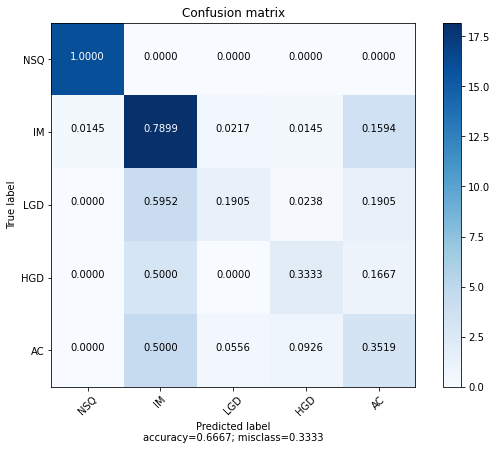

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(np.mean(cnn_test_confusion_matrix,axis=0),Raw_labels.keys(),normalize=True)
plt.show()